In [106]:
%matplotlib notebook

In [108]:
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
from astropy.modeling.fitting import LevMarLSQFitter
import astropy.units as u
from sbpy.photometry import HG, HG1G2, HG12, HG12_Pen16
import importlib
from IPython.display import clear_output

In [15]:
sys.path.append("/Users/jrobinson/atlas-phase-curves/atlas-phase-curves")
from calculate_phase import atlas_SQL_query_df
from calculate_phase import atlas_database_connection
from calculate_phase import solar_apparitions as sa
import tools.database_tools as dbt

In [16]:
importlib.reload(atlas_SQL_query_df)
importlib.reload(dbt)

<module 'tools.database_tools' from '/Users/jrobinson/atlas-phase-curves/atlas-phase-curves/tools/database_tools.py'>

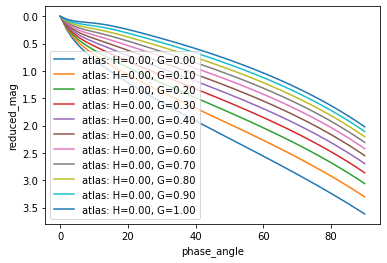

In [46]:
phase_angle = np.linspace(0,90) * u.deg
# phase_angle = np.radians(np.linspace(0,90)) * u.rad

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

# evaluate the HG models

for G_slope in np.linspace(0,1,11):
    HG_model = HG(H = 0 * u.mag, G = G_slope)
    ax1.plot(phase_angle,HG_model(phase_angle),
         label = "atlas: H={:.2f}, G={:.2f}".format(HG_model.H.value,HG_model.G.value))

ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("phase_angle")
ax1.set_ylabel("reduced_mag")

plt.show()

In [166]:
# connect to database
cnx=atlas_database_connection.database_connection().connect()

In [18]:
mpc_number = False
name = "Fitzsimmons"

In [24]:
orbid=atlas_SQL_query_df.get_orb_elements_id(cnx,mpc_number,name)
df_data_filt=atlas_SQL_query_df.atlas_SQL_query_orbid_all(cnx,orbid)

mpc_number=False
name=Fitzsimmons
orbital_elements_id=4985


In [36]:
filt = "o"
orbfit_sep_cut = 1.0
gal_lat_cut = 10.0
lim_mag_cut = 17.5

mask = ((df_data_filt["filter"]==filt) &
        (df_data_filt["orbfit_separation_arcsec"]<=orbfit_sep_cut) &
        (df_data_filt["galactic_latitude"]>=gal_lat_cut) &
        (df_data_filt["limiting_magnitude"]>=lim_mag_cut))
df_data = df_data_filt[mask].sort_values("phase_angle")
    

In [37]:
df_HG = atlas_SQL_query_df.get_astorb_HG(cnx,orbid)
df_HG

,name,mpc_number,G_slope,H_abs_mag,H_abs_mag_o,H_abs_mag_c
0,Fitzsimmons,4985,0.15,13.22,12.888,13.274


In [38]:
model_astorb = HG(H = df_HG.iloc[0]["H_abs_mag_o"] * u.mag, G = df_HG.iloc[0]["G_slope"])

In [39]:
# evaluate the HG models
phase_angle = np.array(df_data[df_data["filter"]=="o"]["phase_angle"]) * u.deg
reduced_mag_astorb = model_astorb(phase_angle)
residual_astorb=df_data[df_data["filter"]=="o"]["reduced_mag"]-np.array(reduced_mag_astorb)

Text(0.5, 1.0, 'Fitzsimmons')

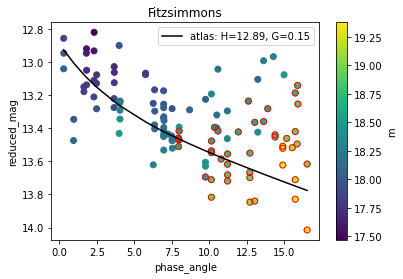

In [43]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

df_plot = df_data
df_plot2 = df_data[df_data["m"]>19.5]

s1 = ax1.scatter(df_plot["phase_angle"],df_plot["reduced_mag"], c = df_plot["m"])
cbar1 = plt.colorbar(s1)
cbar1.set_label("m")

ax1.scatter(df_plot2["phase_angle"],df_plot2["reduced_mag"], facecolor = "none", edgecolor = "r")

# evaluate the HG models
ax1.plot(phase_angle,reduced_mag_astorb,c="k",
         label = "atlas: H={:.2f}, G={:.2f}".format(model_astorb.H.value,model_astorb.G.value))

ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("phase_angle")
ax1.set_ylabel("reduced_mag")
ax1.set_title(name)

In [59]:
a_vals = np.linspace(1.1,6)

In [60]:
mag_dist = 5.0*np.log10(a_vals*(a_vals-1.0))
HG_model = HG(H = 0.0 * u.mag, G = 0.15)
alpha_max = np.arcsin(1.0/a_vals) * u.rad
mag_phase = np.array(HG_model(alpha_max)).astype(float)

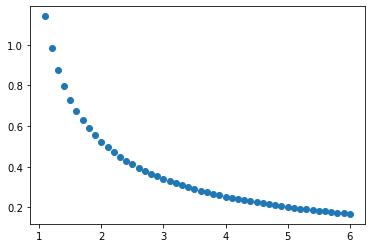

In [61]:
plt.scatter(a_vals,alpha_max)

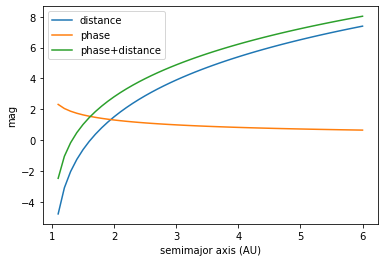

In [63]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.plot(a_vals,mag_dist, label = "distance")
ax1.plot(a_vals,mag_phase, label = "phase")
ax1.plot(a_vals,mag_phase+mag_dist, label = "phase+distance")

# ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("semimajor axis (AU)")
ax1.set_ylabel("mag")

plt.show()

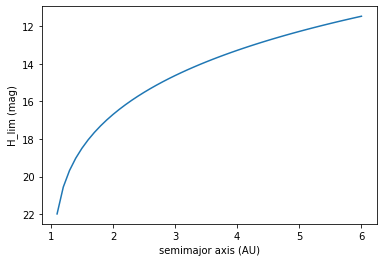

In [66]:
m_app_lim = 19.5 # the brightness limit for ATLAS photometry

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.plot(a_vals, m_app_lim - (mag_phase+mag_dist))

ax1.invert_yaxis()
# ax1.legend()
ax1.set_xlabel("semimajor axis (AU)")
ax1.set_ylabel("H_lim (mag)")

plt.show()

In [67]:
# the maximum reliable absolute magnitude gets brighter as the semimajor axis increases
# i.e. only phase curve fits for larger asteroids can be trusted at larger distances

In [163]:
# look at the properties of atlas photometry

In [167]:
qry="select m, dfitmag, mjd from dophot_photometry;"
df_phot = pd.read_sql_query(qry,cnx)
df_phot

,m,dfitmag,mjd
0,14.229,0.067,57844.650816
1,15.416,0.420,57844.650816
2,15.117,0.135,57844.650816
3,14.471,0.241,57844.650816
4,16.035,0.200,57844.650816
...,...,...,...
100592651,18.474,0.374,NaN
100592652,18.691,0.268,NaN
100592653,18.650,0.236,NaN
100592654,18.609,0.293,NaN


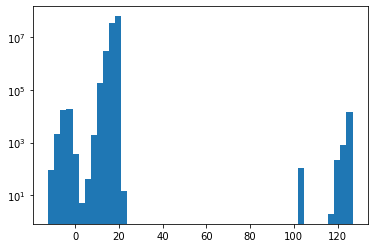

In [168]:
x = plt.hist(df_phot["m"], bins=50, log = True)

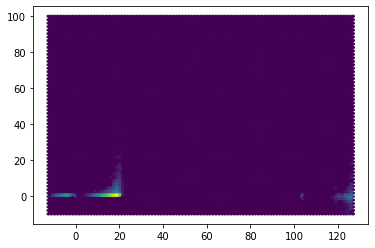

In [171]:
plt.hexbin(df_phot["m"],df_phot["dfitmag"], bins="log")

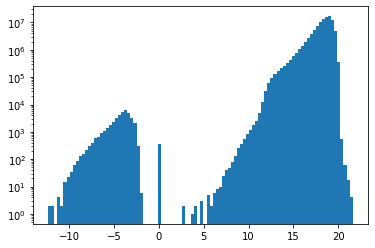

In [80]:
x = plt.hist(df_phot[df_phot["m"]<25]["m"], bins=100, log = True)

In [82]:
# !!! We should probably apply a cut in apparent mag before fitting data
df_phot[df_phot["m"]<25]["m"].max()

21.6

In [77]:
len(df_phot[df_phot["m"]<19.5])/len(df_phot)

0.9283499284480569

In [83]:
len(df_phot[df_phot["m"]>25])/len(df_phot)

0.00015204887322987077

In [131]:
# should also add some buffer space for rotation effects.
# Warner et al. LCDB shows the distribution of lightcurve amplitudes as a function of H

In [136]:
qry="select H_abs_mag,G_slope,a_semimajor_axis, e_eccentricity, i_inclination_deg from orbital_elements;"
df_HG = pd.read_sql_query(qry,cnx)
df_HG

,H_abs_mag,G_slope,a_semimajor_axis,e_eccentricity,i_inclination_deg
0,3.33,0.15,2.766619,0.078636,10.586785
1,4.12,0.15,2.769463,0.229986,34.927066
2,5.12,0.15,2.670422,0.256775,12.992227
3,3.20,0.15,2.361987,0.088401,7.140700
4,7.01,0.15,2.577540,0.188985,5.365435
...,...,...,...,...,...
1248616,24.20,0.15,1.240447,0.383437,6.779660
1248617,22.81,0.15,2.164077,0.478036,3.871140
1248618,23.93,0.15,2.474861,0.535705,3.199410
1248619,23.57,0.15,2.505045,0.506633,4.789470


(-1.21, 34.6)

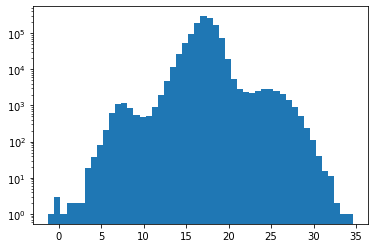

In [137]:
df_plot = df_HG[df_HG["H_abs_mag"]<50]
x = plt.hist(df_plot["H_abs_mag"], bins = 50, log = True)
np.amin(df_plot["H_abs_mag"]),np.amax(df_plot["H_abs_mag"])

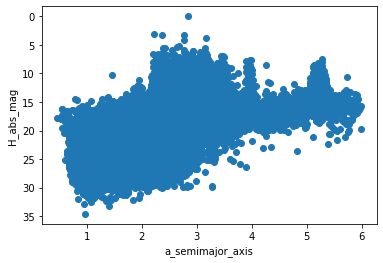

In [143]:
x_plot = "a_semimajor_axis"
y_plot = "H_abs_mag"
df_plot = df_HG[(df_HG["H_abs_mag"]<50) & (df_HG["a_semimajor_axis"]<6)]

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.scatter(df_plot[x_plot],df_plot[y_plot])

ax1.invert_yaxis()
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.show()

In [110]:
df_lcdb = dbt.load_LCDB()

/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_7839/2978398738.py:1: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  df_lcdb = dbt.load_LCDB()


In [117]:
df_lcdb.columns

Index(['Number', 'Name', 'Desig', 'Family', 'CSource', 'Class', 'DiamSource',
       'DiamFlag', 'Diam', 'HSource', 'H', 'HBand', 'GSource', 'G', 'G2',
       'AlbSource', 'AlbFlag', 'Albedo', 'PFlag', 'Period', 'PerDesc',
       'AmpFlag', 'AmpMin', 'AmpMax', 'U', 'Notes', 'IsBinary', 'Pole',
       'Survey', 'ExNotes', 'Private'],
      dtype='object')

In [122]:
good_codes = ["3","3-","2+","2","2-"]

0.38
0.4
0.37
0.38
0.29


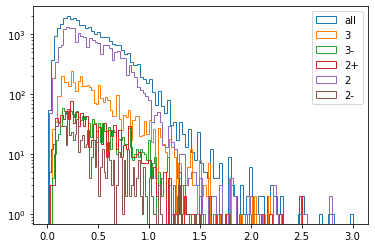

In [126]:
# x_plot = "H"
x_plot = "AmpMax"
df_plot = df_lcdb

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

plt.hist(df_plot[x_plot], histtype = "step", bins = 100, log = True, label = "all")

for U in good_codes:
    _df_plot = df_plot[df_plot["U"]==U]
    plt.hist(_df_plot[x_plot], histtype = "step", bins = 100, log = True, label = U)
    print(np.nanmedian(_df_plot["AmpMax"]))

ax1.legend()
plt.show()

In [127]:
# median peak to peak amplitude of Warner LCDB (high quality)
med_Amp = np.nanmedian(df_lcdb[np.isin(df_lcdb["U"],good_codes)]["AmpMax"])
med_Amp

0.38

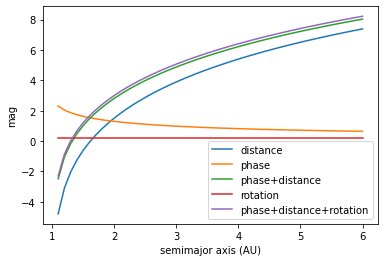

In [128]:
fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.plot(a_vals,mag_dist, label = "distance")
ax1.plot(a_vals,mag_phase, label = "phase")
ax1.plot(a_vals,mag_phase+mag_dist, label = "phase+distance")
ax1.plot(a_vals,[med_Amp/2.0]*len(a_vals), label = "rotation")
ax1.plot(a_vals,mag_phase+mag_dist+(med_Amp/2.0), label = "phase+distance+rotation")

# ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("semimajor axis (AU)")
ax1.set_ylabel("mag")

plt.show()

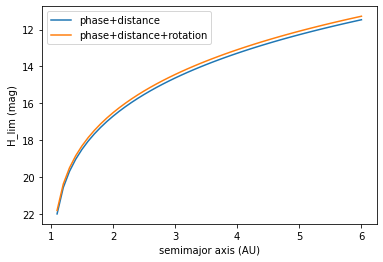

In [129]:
m_app_lim = 19.5 # the brightness limit for ATLAS photometry

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.plot(a_vals, m_app_lim - (mag_phase+mag_dist), label = "phase+distance")
ax1.plot(a_vals, m_app_lim - (mag_phase+mag_dist) - (med_Amp/2.0), label = "phase+distance+rotation")

ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel("semimajor axis (AU)")
ax1.set_ylabel("H_lim (mag)")

plt.show()

In [148]:
def H_lim(a,rot_amp = 0.38, m_app_lim = 19.5):
    
    mag_dist = 5.0*np.log10(a*(a-1.0))

    HG_model = HG(H = 0.0 * u.mag, G = 0.15)
    alpha_max = np.arcsin(1.0/a) * u.rad
    mag_phase = np.array(HG_model(alpha_max)).astype(float)

    return m_app_lim - (mag_phase + mag_dist) - (rot_amp/2.0)

In [154]:
len(H_lim(np.array(df_HG["a_semimajor_axis"])))

/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_7839/1492669464.py:3: RuntimeWarning: invalid value encountered in log10
  mag_dist = 5.0*np.log10(a*(a-1.0))
/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_7839/1492669464.py:6: RuntimeWarning: invalid value encountered in arcsin
  alpha_max = np.arcsin(1.0/a) * u.rad


1248621

1239697
61622
0.04970730751143223


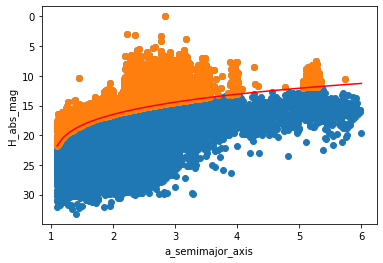

In [172]:
m_app_lim = 19.5 # the brightness limit for ATLAS photometry
# m_app_lim = 20.5 

x_plot = "a_semimajor_axis"
y_plot = "H_abs_mag"
df_plot = df_HG[(df_HG["H_abs_mag"]<50) & (df_HG["a_semimajor_axis"]<6)
               & (df_HG["a_semimajor_axis"]>=1.1)]
print(len(df_plot))

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.scatter(df_plot[x_plot],df_plot[y_plot])
ax1.plot(a_vals, H_lim(a_vals, m_app_lim = m_app_lim), label = "phase+distance+rotation", c="r")

df_plot2 = df_plot[df_plot["H_abs_mag"]<H_lim(np.array(df_plot["a_semimajor_axis"]), m_app_lim = m_app_lim)]
ax1.scatter(df_plot2[x_plot],df_plot2[y_plot])

print(len(df_plot2))
print(len(df_plot2)/len(df_plot))

ax1.invert_yaxis()
ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.show()

In [ ]:
# an absolute magnitude cut after fitting would reject many objects
# should we instead reject the outlying photometry during fitting?
# e.g. when reject when a phase angle bin is > 19.5